Found 12 .lvm file(s) to process:
  - 112288.lvm
  - 112289.lvm
  - 112295.lvm
  - 112296.lvm
  - 112297.lvm
  - 112298.lvm
  - 112299.lvm
  - 112300.lvm
  - 112301.lvm
  - 112302.lvm
  - 112303.lvm
  - 112305.lvm
Loading 112288.lvm...
Loading 112289.lvm...
Loading 112295.lvm...
Loading 112296.lvm...
Loading 112297.lvm...
Loading 112298.lvm...
Loading 112299.lvm...
Loading 112300.lvm...
Loading 112301.lvm...
Loading 112302.lvm...
Loading 112303.lvm...
Loading 112305.lvm...

Heating event summary:
  file   TC            TC_Description  trigger_t  t1_min  t1_max   t2_t  deltaT1  deltaT2  deltaT
112288 TC14 NB Calorimeter 0 (center)     10.800   9.800  10.800 10.800   26.299   29.601   3.302
112288 TC15  NB Calorimeter 1 (lower)     10.800   9.800  10.800 10.800   25.870   27.745   1.875
112288 TC16  NB Calorimeter 2 (right)     10.800   9.800  10.800 10.800   26.116   28.056   1.941
112288 TC17  NB Calorimeter 3 (upper)     10.800   9.800  10.800 10.800   25.809   27.729   1.920
112288 T

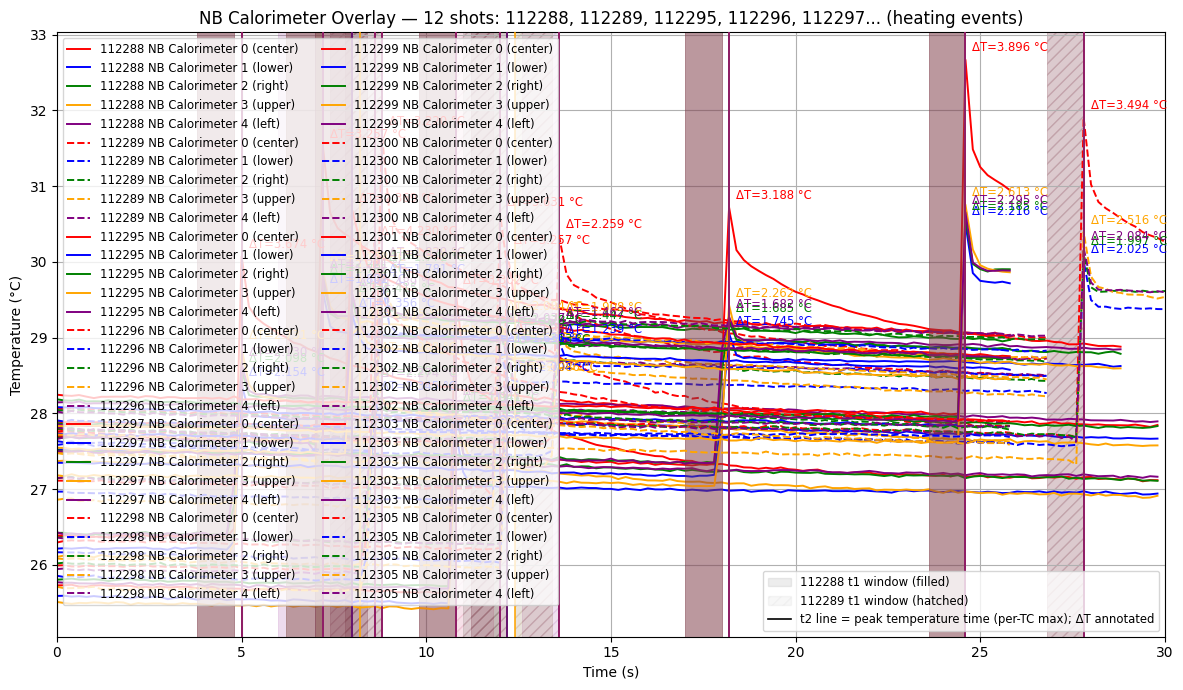


Per-shot deltaT DataFrame (in-memory):
  file  TC14  TC15  TC16  TC17  TC18
112288 3.302 1.875 1.941 1.920 2.040
112289 3.257 2.004 2.113 2.086 2.230
112295 3.674 2.154 2.098 2.731 2.130
112296 3.631 1.636 1.678 2.084 2.037
112297 3.257 1.802 1.781 2.178 2.221
112298 2.259 1.239 1.447 1.908 1.462
112299 3.188 1.745 1.685 2.262 1.682
112300 3.220 1.781 1.772 2.074 1.829
112301 2.369 1.356 1.415 1.415 1.489
112302 3.494 2.025 1.997 2.516 2.084
112303 3.896 2.216 2.185 2.613 2.295
112305 4.230 2.345 2.289 2.988 2.274


In [17]:
## DELTA T DATA 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from pathlib import Path

# Base folder containing LVM files
BASE_FOLDER = Path("/p/ltxdata/thermocouple/LTXB")


shotlist = [
    
    112288,112289,112295,112296,
    112297,112298,112299,112300,112301,112302,
    112303,112305
    
    
]

# time window AND Temp windows(s)
tmin, tmax = 0, 30 
ymin, ymax = None, None

# Mapping TC numbers 
TC_LABELS = {
    "TC14": "NB Calorimeter 0 (center)",
    "TC15": "NB Calorimeter 1 (lower)",
    "TC16": "NB Calorimeter 2 (right)",
    "TC17": "NB Calorimeter 3 (upper)",
    "TC18": "NB Calorimeter 4 (left)",
}

# Colors for each TC (assign actual color names)
TC_COLORS = {
    "TC14": "red",
    "TC15": "blue",
    "TC16": "green",
    "TC17": "orange",
    "TC18": "purple",
}

# data finding
def find_data_start(path: Path) -> int:
    """Find where LVM numeric data starts."""
    end_idx = -1
    with open(path, "r", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end_idx = i
    if end_idx == -1:
        raise RuntimeError("Couldn't find ***End_of_Header*** in file.")
    return end_idx + 1


def load_lvm(path: Path):
    start_row = find_data_start(path)
    df = pd.read_csv(path, sep="\t", skiprows=start_row)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    if "X_Value" not in df.columns:
        raise RuntimeError(f"X_Value column not found in {path}")

    time = pd.to_numeric(df["X_Value"], errors="coerce")

    tc_data = {}
    for num, label in TC_LABELS.items():
        col = f"Temperature_{int(num.replace('TC',''))}"
        if col in df.columns:
            tc_data[num] = pd.to_numeric(df[col], errors="coerce")

    return time, tc_data


def find_lvm_file(folder: Path, shot_spec) -> Path | None:
    """Find an LVM file matching the shot specification (int, string stem, or full filename)."""
    # Normalize to string
    shot_str = str(shot_spec).strip()
    
    # Check if it's a full path that exists
    candidate = Path(shot_str)
    if candidate.is_file():
        return candidate
    
    # Strip .lvm extension if provided
    stem = Path(shot_str).stem
    
    # Get all .lvm files in folder
    lvm_files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() == '.lvm']
    
    # Try exact stem match
    for p in lvm_files:
        if p.stem == stem:
            return p
    
    # Try exact name match
    for p in lvm_files:
        if p.name == shot_str:
            return p
    
    # Try startswith match (handles additional suffixes)
    for p in lvm_files:
        if p.name.startswith(stem):
            return p
    
    return None


# Load files based on shotlist
data_folder = BASE_FOLDER
if shotlist:
    # Load only specified shots
    lvm_files = []
    for shot_spec in shotlist:
        found = find_lvm_file(data_folder, shot_spec)
        if found:
            lvm_files.append(found)
        else:
            print(f"Warning: shot '{shot_spec}' not found in {data_folder}")
    
    if not lvm_files:
        raise RuntimeError(f"None of the specified shots were found in {data_folder}")
else:
    # Load all .lvm files in the folder (sorted A-Z)
    lvm_files = sorted(data_folder.glob("*.lvm"))
    if not lvm_files:
        raise RuntimeError(f"No .lvm files found in {data_folder}")

print(f"Found {len(lvm_files)} .lvm file(s) to process:")
for f in lvm_files:
    print(f"  - {f.name}")

# Load data for all selected files
all_file_data = {}
for lvm_file in lvm_files:
    try:
        print(f"Loading {lvm_file.name}...")
        time, data = load_lvm(lvm_file)
        all_file_data[lvm_file.stem] = (time, data)
    except Exception as e:
        print(f"Error loading {lvm_file}: {e}")


def detect_heating_event(time: pd.Series, temp: pd.Series, rate_threshold: float = 0.2):
    #detect first heating event where |dT/dt| > rate_threshold.
    #Returns dict: trigger_t, t1_min, t1_max, t2_t, deltaT1, deltaT2, deltaT.
    
    time = pd.to_numeric(time, errors='coerce')
    temp = pd.to_numeric(temp, errors='coerce')

    dtemp = temp.diff()
    dt = time.diff()
    with np.errstate(divide='ignore', invalid='ignore'):
        rate = dtemp / dt

    cond = rate.abs() > rate_threshold
    if not cond.any():
        return {'trigger_t': None, 't1_min': None, 't1_max': None,
                't2_t': None, 'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan}

    trigger_idx = cond[cond].index[0]
    trigger_t = float(time.iloc[trigger_idx])

    #1-second window prior to the trigger
    t1_min = trigger_t - 1.0
    t1_max = trigger_t

    mask_t1 = (time >= t1_min) & (time <= t1_max)
    deltaT1 = float(temp[mask_t1].mean()) if mask_t1.any() else np.nan

    #t2 is themax temperature for this thermocouple
    try:
        idx_t2 = temp.idxmax()
        t2_t = float(time.loc[idx_t2])
        deltaT2 = float(temp.loc[idx_t2])
    except Exception:
        t2_t = None
        deltaT2 = np.nan

    deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)

    return {'trigger_t': trigger_t, 't1_min': t1_min, 't1_max': t1_max,
            't2_t': t2_t, 'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}


def compute_global_trigger(time: pd.Series, data: dict) -> float | None:
    #per-shot trigger time using aggregate positive dT/dt.

    #Approach: build a DataFrame of all TCs, compute per-column derivative,
    #clip negative rates to 0, sum across TCs, and take the argmax time.
    #Returns None if data insufficient.
    #
    if not data:
        return None
    try:
        df = pd.DataFrame({k: pd.to_numeric(v, errors='coerce') for k, v in data.items()})
        # Align with time
        t = pd.to_numeric(time, errors='coerce')
        # Derivative per TC
        dt = t.diff()
        with np.errstate(divide='ignore', invalid='ignore'):
            rates = df.diff().divide(dt, axis=0)
        pos = rates.clip(lower=0)
        agg = pos.sum(axis=1)
        idx = agg.idxmax()
        if pd.isna(idx):
            return None
        return float(t.loc[idx])
    except Exception:
        return None


plt.figure(figsize=(12, 7))
ax = plt.gca()

rows = []
for idx, (file_label, (time, data)) in enumerate(all_file_data.items()):
    for num, pretty in TC_LABELS.items():
        color = TC_COLORS.get(num, 'black')
        if num not in data:
            rows.append({'file': file_label, 'TC': num, 'trigger_t': None,
                         't1_min': None, 't1_max': None, 't2_t': None,
                         'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan})
            continue

        temp = data[num]
        # Use per-TC detection (threshold kept at 0.5 as in the original)
        res = detect_heating_event(time, temp, rate_threshold=0.5)
        # If per-TC trigger not found, try computing baseline using a global trigger
        if res.get('trigger_t') is None:
            gtrig = compute_global_trigger(time, data)
            if gtrig is not None:
                # compute deltaT1 using 1s window prior to global trigger
                t_arr = pd.to_numeric(time, errors='coerce')
                temp_ser = pd.to_numeric(temp, errors='coerce')
                t1_min = gtrig - 1.0
                t1_max = gtrig
                mask_t1 = (t_arr >= t1_min) & (t_arr <= t1_max)
                deltaT1 = float(temp_ser[mask_t1].mean()) if mask_t1.any() else np.nan
                # t2 is per-TC maximum
                try:
                    idx_t2 = temp_ser.idxmax()
                    t2_t = float(t_arr.loc[idx_t2])
                    deltaT2 = float(temp_ser.loc[idx_t2])
                except Exception:
                    t2_t = None
                    deltaT2 = np.nan
                deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)
                res = {'trigger_t': float(gtrig), 't1_min': t1_min, 't1_max': t1_max,
                       't2_t': t2_t, 'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}
        rows.append({**{'file': file_label, 'TC': num}, **res})

        # Alternate linestyle for different files so overlapping traces remain visible
        linestyle = '-' if idx % 2 == 0 else '--'
        ax.plot(time, temp, color=color, linestyle=linestyle, linewidth=1.4,
                label=f"{file_label} {pretty}")

        # Draw t1 window: filled for even-indexed files, hatched for odd-indexed files
        if res['t1_min'] is not None and res['t1_max'] is not None:
            if idx % 2 == 0:
                ax.axvspan(res['t1_min'], res['t1_max'], facecolor=color, alpha=0.14,
                           edgecolor=color, linewidth=0.6, zorder=2)
            else:
                ax.axvspan(res['t1_min'], res['t1_max'], facecolor=color, alpha=0.06,
                           edgecolor=color, linewidth=0.6, hatch='///', zorder=1)

        # Draw t2 as a vertical line and annotate ΔT when available
        if res['t2_t'] is not None:
            ax.axvline(res['t2_t'], color=color, linestyle='-', linewidth=1.2, alpha=0.95, zorder=4)
            if pd.notna(res.get('deltaT')) and pd.notna(res.get('deltaT2')):
                ax.annotate(f"ΔT={res['deltaT']:.3f} °C",
                            xy=(res['t2_t'], res['deltaT2']), xytext=(5, 6),
                            textcoords='offset points', color=color, fontsize='small', zorder=5)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (°C)")
loaded_keys = list(all_file_data.keys())
title_shots = ", ".join(loaded_keys[:5]) + ("..." if len(loaded_keys) > 5 else "")
ax.set_title(f"NB Calorimeter Overlay — {len(loaded_keys)} shots: {title_shots} (heating events)")
ax.grid(True)
trace_legend = ax.legend(ncol=2, fontsize='small', loc='upper left')
ax.add_artist(trace_legend)

# Map TC to descriptive names in the summary table
df_res = pd.DataFrame(rows)
df_res['TC_Description'] = df_res['TC'].map(TC_LABELS)

# Legend entries explaining the t1 window styles and t2 meaning
l1_desc = 't2 line = peak temperature time (per-TC max); ΔT annotated'
p1_label = f"{loaded_keys[0]} t1 window (filled)" if loaded_keys else "t1 window (filled)"
p2_label = f"{loaded_keys[1]} t1 window (hatched)" if len(loaded_keys) > 1 else "t1 window (hatched)"
p1 = mpatches.Patch(facecolor='gray', alpha=0.14, edgecolor='gray', label=p1_label)
p2 = mpatches.Patch(facecolor='gray', alpha=0.06, edgecolor='gray', hatch='///', label=p2_label)
l1 = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1.2, label=l1_desc)
ax.legend(handles=[p1, p2, l1], loc='lower right', fontsize='small')

# Print updated summary table (same columns as before)
cols = ['file', 'TC', 'TC_Description', 'trigger_t', 't1_min', 't1_max', 't2_t', 'deltaT1', 'deltaT2', 'deltaT']
df_res = df_res[cols]
pd.set_option('display.float_format', lambda x: f"{x:.3f}" if pd.notna(x) else "nan")
print('\nHeating event summary:')
print(df_res.to_string(index=False))

if ymin is not None and ymax is not None:
    ax.set_ylim(ymin, ymax)
ax.set_xlim(tmin, tmax)
plt.tight_layout()
plt.show()

# Build a per-shot DataFrame with one row per shot and columns for each TC's deltaT
if not df_res.empty:
    pivot = df_res.pivot_table(index='file', columns='TC', values='deltaT', aggfunc='first')
    # Ensure columns order for the expected 5 TCs
    expected_tcs = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']
    for tc in expected_tcs:
        if tc not in pivot.columns:
            pivot[tc] = np.nan
    pivot = pivot.reset_index()
    # Optional: reorder columns
    deltaT_df = pivot[['file'] + expected_tcs]
else:
    deltaT_df = pd.DataFrame(columns=['file', 'TC14', 'TC15', 'TC16', 'TC17', 'TC18'])

print('\nPer-shot deltaT DataFrame (in-memory):')
print(deltaT_df.to_string(index=False))
# ======= WRITE PER-FILE SUMMARY TEXTS =======

# Base output directory (must exist)



Files will be ordered as:
  0: 112288
  1: 112289
  2: 112295
  3: 112296
  4: 112297
  5: 112298
  6: 112299
  7: 112300
  8: 112301
  9: 112302
  10: 112303
  11: 112305


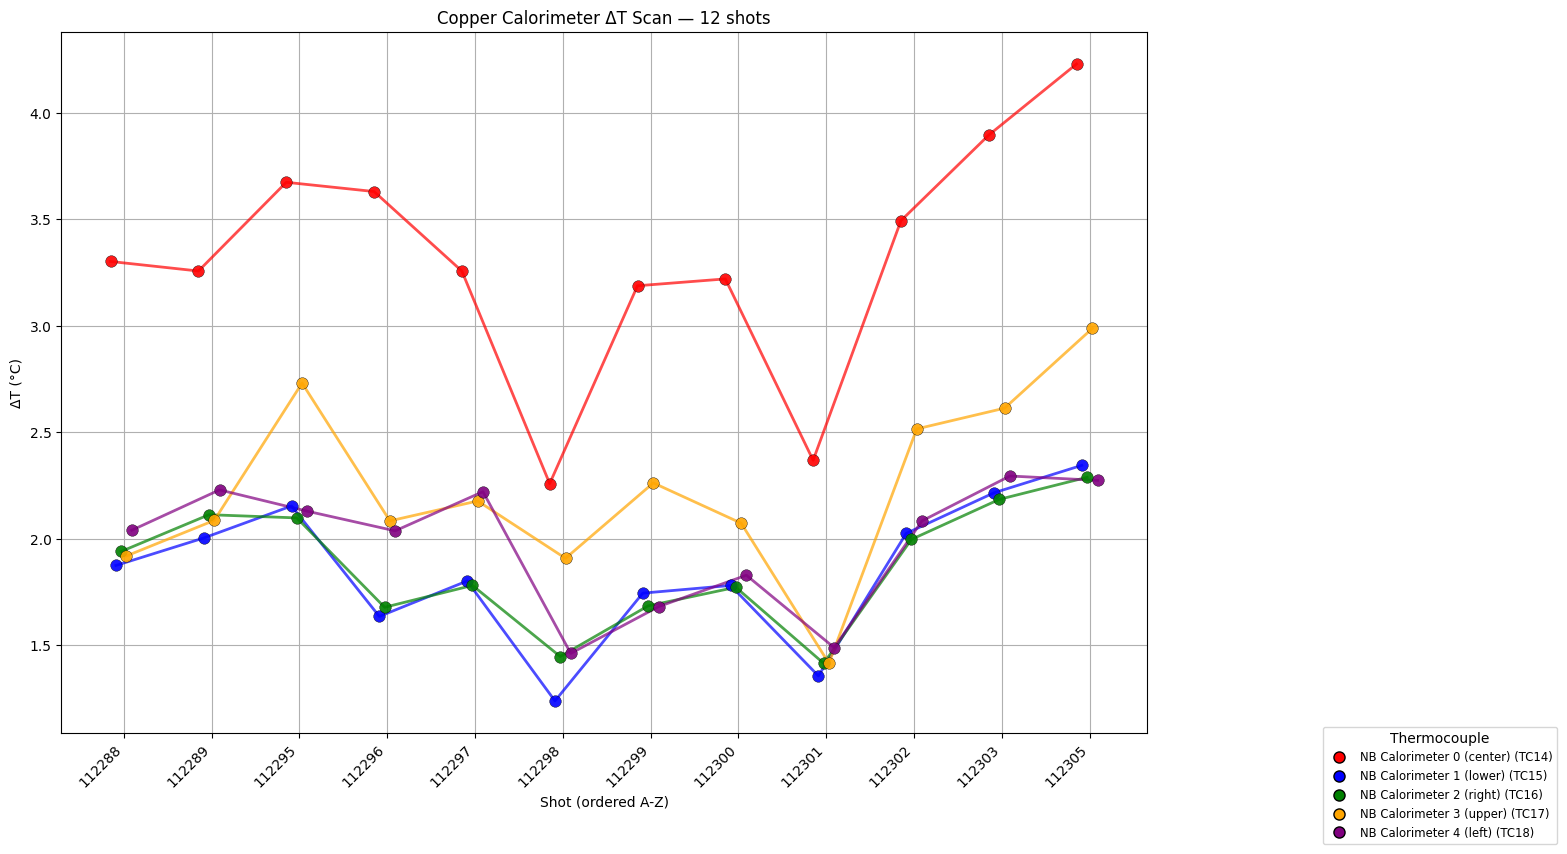


Scan plot created for 12 shots with 5 thermocouples


In [18]:
## SHOT INDEX SCAN PLOT (based on Neutralizer_Scan_test logic)

import re
from matplotlib.lines import Line2D

# Use the deltaT_df created above - it already has the structure we need
# Columns: ['file', 'TC14', 'TC15', 'TC16', 'TC17', 'TC18']

if deltaT_df.empty:
    print("No data to plot - deltaT_df is empty")
else:
    # Natural sort function to order shots properly (numeric then alphabetical)
    def natural_sort_key(text):
        """
        Convert a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
        """
        def tryint(s):
            try:
                return int(s)
            except ValueError:
                return s.lower()
        
        return [tryint(c) for c in re.split(r'(\d+)', text)]
    
    # Get unique files and sort them
    unique_files = list(deltaT_df['file'].unique())
    file_order = sorted(unique_files, key=natural_sort_key)
    
    print("Files will be ordered as:")
    for i, f in enumerate(file_order):
        print(f"  {i}: {f}")
    
    # Create shot index mapping
    file_to_idx = {f: i for i, f in enumerate(file_order)}
    
    # Create the scan plot
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # Plot each TC with connecting lines
    ordered_tcs = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']
    
    for i, tc in enumerate(ordered_tcs):
        if tc not in deltaT_df.columns:
            continue
        
        color = TC_COLORS.get(tc, 'gray')
        label = TC_LABELS.get(tc, tc)
        
        # Get data for this TC
        tc_data = []
        shot_indices = []
        
        for file in file_order:
            file_row = deltaT_df[deltaT_df['file'] == file]
            if not file_row.empty:
                deltaT_val = file_row[tc].values[0]
                if pd.notna(deltaT_val):
                    shot_idx = file_to_idx[file]
                    # Small horizontal offset per TC so points don't overlap
                    offset = (i - len(ordered_tcs)/2) * 0.06
                    shot_indices.append(shot_idx + offset)
                    tc_data.append(deltaT_val)
        
        if shot_indices:
            # Plot line first (behind points)
            ax.plot(shot_indices, tc_data, color=color, linewidth=2, alpha=0.7, linestyle='-')
            # Plot scatter points on top
            ax.scatter(shot_indices, tc_data, s=70, alpha=0.9, c=color, marker='o', 
                      edgecolor='k', linewidth=0.3, zorder=5)
    
    # Set x-axis labels
    ax.set_xticks(list(range(len(file_order))))
    ax.set_xticklabels(file_order, rotation=45, ha='right')
    ax.set_xlabel('Shot (ordered A-Z)')
    ax.set_ylabel('ΔT (°C)')
    ax.set_title(f'Copper Calorimeter ΔT Scan — {len(file_order)} shots')
    ax.grid(True)
    
    # Adjust layout to make room for legend
    fig.tight_layout()
    fig.subplots_adjust(right=0.72, bottom=0.18)
    
    # Build legend handles for the TCs
    tc_handles = []
    for tc in ordered_tcs:
        lbl = TC_LABELS.get(tc, tc)
        col = TC_COLORS.get(tc, 'gray')
        tc_handles.append(Line2D([0], [0], marker='o', color='w', label=f"{lbl} ({tc})", 
                                 markerfacecolor=col, markersize=8, markeredgecolor='k'))
    
    # Place the TC legend outside the axes
    fig.legend(handles=tc_handles, title='Thermocouple', loc='lower right', 
              bbox_to_anchor=(0.98, 0.05), bbox_transform=fig.transFigure, 
              fontsize='small', frameon=True)
    
    plt.show()
    
    print(f"\nScan plot created for {len(file_order)} shots with {len(ordered_tcs)} thermocouples")
